# MultiClass Classification to determine in which period band engine will fail

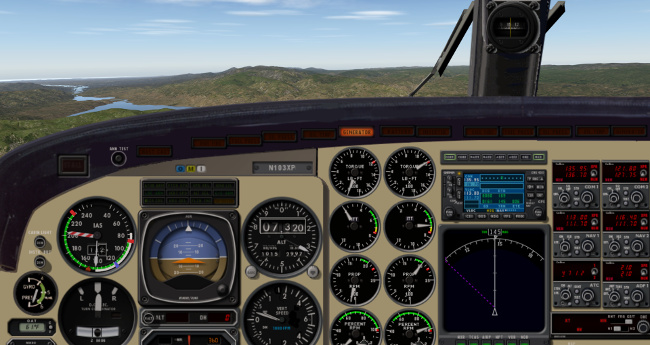

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
from itertools import cycle
from sklearn import metrics
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer

### Load Data:

In [2]:
# load training data 
df_train = pd.read_csv('train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10,av11,av12,av13,av14,av15,av16,av17,av18,av19,av20,av21,sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8,sd9,sd10,sd11,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.0600,9046.190000,1.3,47.470,521.660,2388.020,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,641.985000,1590.760000,1401.870000,14.62,21.61,554.055000,2388.0500,9045.130000,1.3,47.480,521.970,2388.045,8135.055000,8.425650,0.03,392.000000,2388.0,100.0,39.030000,23.421300,0.0,0.233345,1.499066,1.796051,0.0,0.0,0.431335,0.014142,1.499066,0.0,0.014142,0.438406,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,642.106667,1589.836667,1402.646667,14.62,21.61,554.123333,2388.0600,9047.733333,1.3,47.410,522.120,2388.040,8134.446667,8.423033,0.03,391.333333,2388.0,100.0,39.003333,23.395600,0.0,0.267644,1.918654,1.850009,0.0,0.0,0.327159,0.020000,4.632023,0.0,0.121655,0.404475,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,518.67,642.167500,1588.075000,1402.452500,14.62,21.61,554.205000,2388.0725,9048.170000,1.3,47.340,522.305,2388.050,8134.292500,8.409325,0.03,391.500000,2388.0,100.0,38.972500,23.390175,0.0,0.250117,3.855909,1.559645,0.0,0.0,0.313103,0.029861,3.881555,0.0,0.171659,0.495950,0.029439,3.050906,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,518.67,642.208000,1587.030000,1403.206000,14.62,21.61,554.164000,2388.0700,9049.566000,1.3,47.328,522.282,2388.048,8134.194000,8.413340,0.03,391.800000,2388.0,100.0,38.958000,23.393020,0.0,0.234776,4.075678,2.159440,0.0,0.0,0.286234,0.026458,4.587366,0.0,0.151063,0.432574,0.025884,2.651326,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
# load test data 
df_test = pd.read_csv('test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10,av11,av12,av13,av14,av15,av16,av17,av18,av19,av20,av21,sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8,sd9,sd10,sd11,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,518.67,642.266,1586.998,1399.918,14.62,21.61,554.116,2388.082,9050.324,1.3,47.288,521.924,2388.064,8132.032,8.42620,0.03,392.0,2388.0,100.0,38.924,23.37350,0.0,0.393865,4.683863,1.362689,0.0,0.0,0.338275,0.008367,5.200801,0.0,0.152217,0.261591,0.028810,3.302941,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,47.67,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,518.67,642.672,1588.342,1406.778,14.62,21.61,553.748,2388.108,9047.032,1.3,47.506,521.596,2388.102,8127.672,8.44226,0.03,392.2,2388.0,100.0,38.902,23.27434,0.0,0.167839,1.559670,4.535578,0.0,0.0,0.357729,0.044385,3.044901,0.0,0.098387,0.450255,0.008367,1.370062,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,47.88,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,518.67,642.874,1592.640,1413.350,14.62,21.61,552.702,2388.166,9047.406,1.3,47.706,520.722,2388.174,8129.666,8.45868,0.03,394.2,2388.0,100.0,38.686,23.24412,0.0,0.287367,4.205152,3.357976,0.0,0.0,0.292609,0.028810,1.608782,0.0,0.111937,0.418234,0.029665,2.979090,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,47.65,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581,518.67,642.786,1591.918,1410.736,14.62,21.61,553.444,2388.116,9054.800,1.3,47.642,521.434,2388.114,8134.328,8.45182,0.03,393.6,2388.0,100.0,38.758,23.25156,0.0,0.106442,2.818611,5.282105,0.0,0.0,0.590999,0.058138,4.536805,0.0,0.046583,0.363291,0.027019,0.622953,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,47.46,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117,518.67,642.702,1591.568,1411.796,14.62,21.61,553.158,2388.122,9053.330,1.3,47.536,521.062,2388.134,8128.798,8.43662,0.03,393.4,2388.0,100.0,38.810,23.29114,0.0,0.259557,1.496620,5.309739,0.0,0.0,0.454170,0.038987,3.212717,0.0,0.159154,0.260231,0.023022,1.923609,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


Create features sets required to subset the original dataframes into original features and original + extracted features

Create training and test data labels series, and convert them to binary format as required by multiclass classification algorithms.


In [21]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


### Multiclass Classification:

Define helper fuctions

In [22]:
#@title MultiClass-Classify function
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
    X_train = df_train[features]
    X_test = df_test[features]  
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)  
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred 
    return grid_search.best_estimator_, y_pred, y_score


In [23]:
#@title Multi-class Metric function
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        } 
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model] 
    n_classes = y_train.shape[1] 
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict() 
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }
    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)
    if plot_out:  
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    return df_metrics, df_prc_thresh, df_roc_thresh

Using the above functions let us model and evaluate some binary classification algorithms

__In model names:__  

__B__ stands for applying the model on the original features set, __B__efore feature extraction  
__A__ stands for applying the model on the original + extracted features set, __A__fter feature extraction

# Decision Tree Classifier

Before Feature Extraction


Best Parameters:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1  0]
 [12  2  1]
 [ 1  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91        75
           1       0.67      0.13      0.22        15
           2       0.90      0.90      0.90        10

    accuracy                           0.85       100
   macro avg       0.81      0.67      0.68       100
weighted avg       0.83      0.85      0.81       100


Metrics:
       

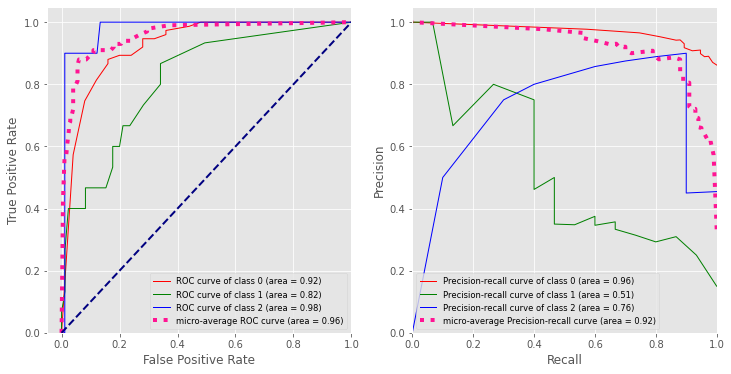

In [7]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'
clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtrb)
metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, y_score_dtrb, print_out=True, plot_out=True)


After Feature Extraction


Best Parameters:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  0  1]
 [10  1  4]
 [ 1  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       1.00      0.07      0.12        15
           2       0.64      0.90      0.75        10

    accuracy                           0.84       100
   macro avg       0.84      0.65      0.60       100
weighted avg       0.87      0.84      0.79       100


Metrics:
       

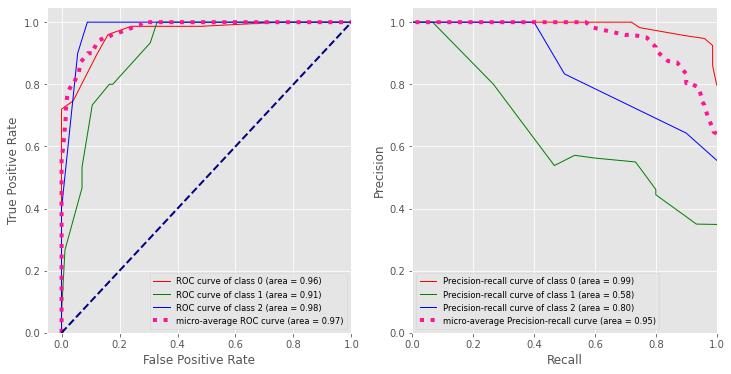

In [8]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'
clf_dtra, y_pred_dtra, y_score_dtra = multiclass_classify(model, clf_dtrb, 
                                            features_extr, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtra)
metrics_dtra, prc_dtra, roc_dtra = multiclass_metrics(model, y_test, y_pred_dtra, y_score_dtra, print_out=True, plot_out=True)


In [9]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
Accuracy,0.840000,0.840000
macro F1,0.684053,0.607906
micro F1,0.861538,0.857143
macro Precision,0.818970,0.852146
micro Precision,0.884211,0.875000
macro Recall,0.668889,0.651111
micro Recall,0.840000,0.840000
macro ROC AUC,0.905594,0.949857
micro ROC AUC,0.956625,0.973550


# Logisic Regression

Before Feature Extraction

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[75  0  0]
 [13  0  2]
 [ 3  0  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
   

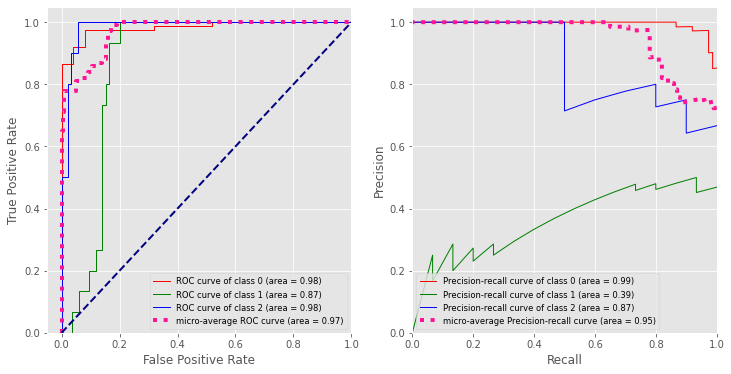

In [10]:
model = 'Logistic Regression B'

clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, prc_lgrb, roc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)


After Feature Extraction

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0  0]
 [14  0  1]
 [ 4  0  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        75
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


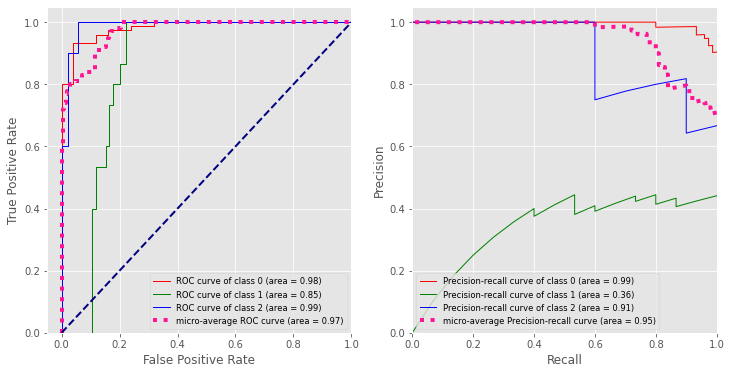

In [11]:
model = 'Logistic Regression A'

clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, prc_lgra, roc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)


In [12]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.810000,0.810000
macro F1,0.553947,0.551750
micro F1,0.835052,0.852632
macro Precision,0.549455,0.586919
micro Precision,0.861702,0.900000
macro Recall,0.562222,0.533333
micro Recall,0.810000,0.810000
macro ROC AUC,0.945027,0.941515
micro ROC AUC,0.970900,0.971800


# Random Forest Classifier

Before Feature Extraction


Best Parameters:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[75  0  0]
 [11  2  2]
 [ 3  1  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        75
           1       0.67      0.13      0.22        15
           2       0.75      0.60      0.67        10

    accuracy                           0.83       100
   macr

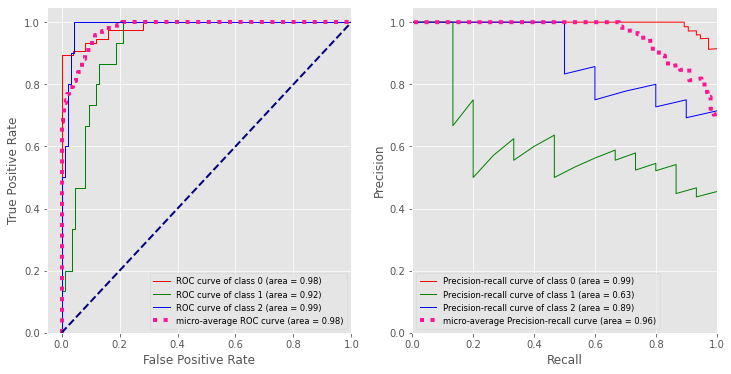

In [13]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, prc_rfcb, roc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, y_score_rfcb, print_out=True, plot_out=True)

After Feature Extraction


Best Parameters:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1  0]
 [12  3  0]
 [ 0  2  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        75
           1       0.50      0.20      0.29        15
           2       1.00      0.80      0.89        10

    accuracy                           0.85       100
   macr

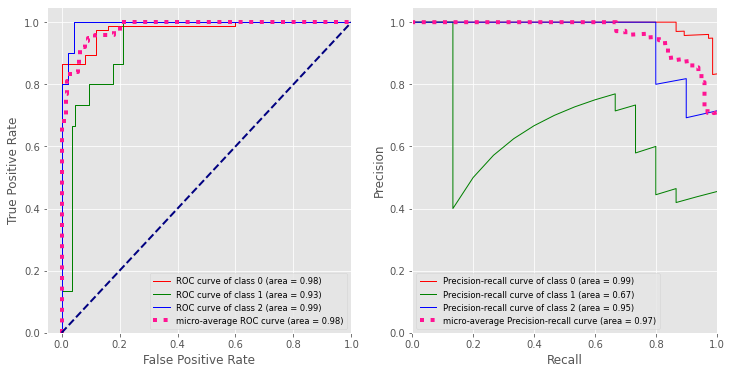

In [15]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfca, y_pred_rfca, y_score_rfca = multiclass_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, prc_rfca, roc_rfca = multiclass_metrics(model, y_test, y_pred_rfca, y_score_rfca, print_out=True, plot_out=True)



In [16]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.820000,0.850000
macro F1,0.612536,0.705759
micro F1,0.854167,0.867347
macro Precision,0.776749,0.800813
micro Precision,0.891304,0.885417
macro Recall,0.573333,0.662222
micro Recall,0.820000,0.850000
macro ROC AUC,0.964340,0.967744
micro ROC AUC,0.978550,0.980600


# Comparing all tried multiclass classification algorithms 

In [17]:
#compare all models
metrics_mc = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc], axis=1).T
metrics_mc

,Accuracy,macro F1,micro F1,macro Precision,micro Precision,macro Recall,micro Recall,macro ROC AUC,micro ROC AUC
Logistic Regression B,0.81,0.553947,0.835052,0.549455,0.861702,0.562222,0.81,0.945027,0.970900
Logistic Regression A,0.81,0.551750,0.852632,0.586919,0.900000,0.533333,0.81,0.941515,0.971800
Decision Tree B,0.84,0.684053,0.861538,0.818970,0.884211,0.668889,0.84,0.905594,0.956625
Decision Tree A,0.84,0.607906,0.857143,0.852146,0.875000,0.651111,0.84,0.949857,0.973550
Random Forest B,0.82,0.612536,0.854167,0.776749,0.891304,0.573333,0.82,0.964340,0.978550
Random Forest A,0.85,0.705759,0.867347,0.800813,0.885417,0.662222,0.85,0.967744,0.980600


Neural Net Multi-layer Perceptron classifier clearly outperformed other models in all metrics, with the
Random Forests classifier scoring in the second place.

Text(0.5, 1.0, 'micro Precision Recall')

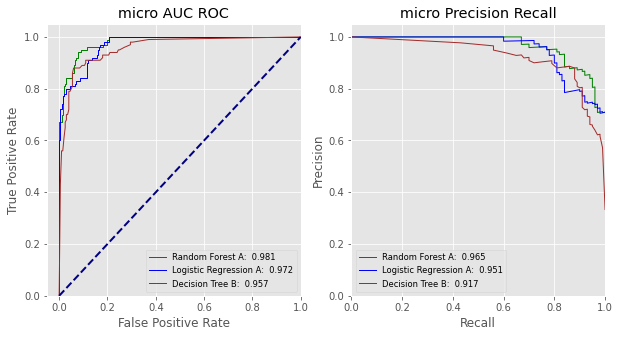

In [18]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)
ax1.plot(roc_rfca.FPR['micro'], roc_rfca.TPR['micro'], color='green', lw=1, label= roc_rfca.Model['micro'] + ':  %.3f' % roc_rfca.AUC['micro'])
ax1.plot(roc_lgra.FPR['micro'], roc_lgra.TPR['micro'], color='blue', lw=1, label= roc_lgra.Model['micro'] + ':  %.3f' % roc_lgra.AUC['micro'])
ax1.plot(roc_dtrb.FPR['micro'], roc_dtrb.TPR['micro'], color='brown', lw=1, label= roc_dtrb.Model['micro'] + ':  %.3f' % roc_dtrb.AUC['micro'])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('micro AUC ROC')
ax2.plot(prc_rfca.Recall['micro'], prc_rfca.Precision['micro'], color='green', lw=1, label= prc_rfca.Model['micro'] + ':  %.3f' % prc_rfca['Avg Precision']['micro'])
ax2.plot(prc_lgra.Recall['micro'], prc_lgra.Precision['micro'], color='blue', lw=1, label= prc_lgra.Model['micro'] + ':  %.3f' % prc_lgra['Avg Precision']['micro'])
ax2.plot(prc_dtrb.Recall['micro'], prc_dtrb.Precision['micro'], color='brown', lw=1, label= prc_dtrb.Model['micro'] + ':  %.3f' % prc_dtrb['Avg Precision']['micro'])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('micro Precision Recall')

The graph shows Neural Network MLP as the best model in both AUC ROC and Precision-Reall curves.

#Multiclass Classification Summary:

1. Accuracy of Random Forest Classifier is after feature extraction is higher (85 %)
2. In terms of AUC-ROC metric, Random Forest Classifier has highest value (98.02%)